# Efficient Frontier of a Multi-Asset Portfolio

### Note: Currently does not support inclusion of risk-free asset and Markowitz Procdedure is suboptimal in real life situations

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

%matplotlib inline

### Load the data from 'ind30_m_vw_rets.csv' and format

In [2]:
ind = pd.read_csv('../data/ind30_m_vw_rets.csv', header = 0, index_col = 0)/100
ind.index = pd.to_datetime(ind.index, format = '%Y%m').to_period('M')
ind.columns = ind.columns.str.strip()

In [3]:
ind.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2018-08,-0.0038,-0.0186,-0.0543,0.0289,-0.0447,0.0254,0.0526,0.0446,0.0001,0.0380,...,0.0295,0.0524,0.0993,-0.0034,0.0291,0.0366,0.0911,0.0364,0.0245,0.0299
2018-09,-0.0032,0.0019,0.0537,-0.0009,-0.0221,0.0107,0.0130,0.0199,-0.0287,-0.0638,...,0.0174,-0.0037,-0.0033,-0.0030,0.0105,-0.0148,0.0061,0.0251,-0.0193,0.0116
2018-10,0.0102,-0.0157,0.0790,-0.1596,-0.0666,-0.0051,-0.1014,-0.0884,-0.1250,-0.2579,...,-0.0050,-0.0920,-0.0806,-0.0982,-0.0975,-0.0788,-0.1021,-0.0171,-0.0545,-0.0599
2018-11,0.0272,0.0579,-0.0843,-0.0065,0.0325,0.0644,-0.0099,0.0632,0.0496,0.0292,...,0.0254,0.0129,-0.0505,0.0822,0.0617,0.0318,0.0159,0.0616,0.0289,0.0348
2018-12,-0.0973,-0.0969,-0.1580,-0.0824,-0.1535,-0.0557,-0.0728,-0.0840,-0.0776,-0.1009,...,-0.0884,-0.0765,-0.0923,-0.0863,-0.1519,-0.1121,-0.0919,-0.0628,-0.1144,-0.0693


### Annualize returns of the years 2014-2018 and create covariance matrix

In [4]:
def annualize_returns(r, periods_per_year):
    """
    Calculates the annualized returns of the data frame
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [5]:
er = annualize_returns(ind['2014':'2018'],12)
cov = ind['2014':'2018'].cov()
cov

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0.001049,0.000886,0.001137,0.000575,0.000877,0.000757,0.000578,0.000651,0.000746,0.000885,...,0.000806,0.000610,0.000644,0.000838,0.000676,0.000705,0.000840,5.960066e-04,0.000599,0.000697
Beer,0.000886,0.001158,0.001199,0.000372,0.000769,0.000807,0.000448,0.000677,0.000637,0.000939,...,0.000719,0.000567,0.000624,0.000836,0.000699,0.000550,0.000642,5.562742e-04,0.000424,0.000602
Smoke,0.001137,0.001199,0.002936,0.000257,0.000559,0.000913,0.000329,0.000403,0.000420,0.000321,...,0.000946,0.000433,0.000599,0.000758,0.000670,0.000414,0.000413,5.328949e-04,0.000327,0.000749
Games,0.000575,0.000372,0.000257,0.003193,0.001550,0.000322,0.000954,0.001263,0.001747,0.001758,...,0.000947,0.001790,0.001633,0.001183,0.001271,0.001202,0.001450,7.733721e-04,0.001248,0.000701
Books,0.000877,0.000769,0.000559,0.001550,0.002608,0.000812,0.001126,0.001349,0.001787,0.002160,...,0.001298,0.001136,0.001195,0.001555,0.001501,0.001572,0.001379,9.987197e-04,0.001575,0.001022
Hshld,0.000757,0.000807,0.000913,0.000322,0.000812,0.000974,0.000527,0.000670,0.000694,0.000865,...,0.000746,0.000488,0.000569,0.000820,0.000720,0.000609,0.000676,4.939002e-04,0.000497,0.000665
Clths,0.000578,0.000448,0.000329,0.000954,0.001126,0.000527,0.001694,0.000783,0.000789,0.001340,...,0.000680,0.000746,0.000672,0.000771,0.000922,0.000848,0.001223,6.198117e-04,0.000873,0.000703
Hlth,0.000651,0.000677,0.000403,0.001263,0.001349,0.000670,0.000783,0.001657,0.001358,0.001563,...,0.000838,0.001074,0.001082,0.001249,0.001244,0.001197,0.001183,6.615860e-04,0.001134,0.000853
Chems,0.000746,0.000637,0.000420,0.001747,0.001787,0.000694,0.000789,0.001358,0.002411,0.002010,...,0.001034,0.001329,0.001467,0.001682,0.001695,0.001515,0.001214,9.228977e-04,0.001543,0.001186
Txtls,0.000885,0.000939,0.000321,0.001758,0.002160,0.000865,0.001340,0.001563,0.002010,0.003912,...,0.001051,0.001416,0.001617,0.001800,0.001603,0.001583,0.001647,1.098463e-03,0.001548,0.001121


### Functions

In [6]:
def portfolio_return(weights, returns):
    """
    Weight -> Returns
    """
    return weights.T @ returns

In [7]:
def portfolio_vol(weights, covmat):
    """
    Weight -> Vol
    """
    return (weights.T @ covmat @ weights)**.5

In [8]:
def minimize_vol(target_return, er, cov):
    """
    target return -> weight
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(portfolio_vol, init_guess,
                       args = (cov,), method = 'SLSQP',
                       options = {'disp': False},
                       constraints = (return_is_target, weights_sum_to_1),
                       bounds = bounds
                      )
    return results.x

In [9]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

In [10]:
def plot_ef(n_points, er, cov):
    """
    Plots asset efficient frontier of mulitple assets
    """
    weights = optimal_weights(n_points, er, cov)
    returns = [portfolio_return(w, er) for w in weights]
    volatility = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        'Returns': returns,
        'Volatility': volatility
    })
    return ef.plot.line(x = 'Volatility', y = 'Returns', style = '.-')

### Choose which assets and plot

<AxesSubplot:xlabel='Volatility'>

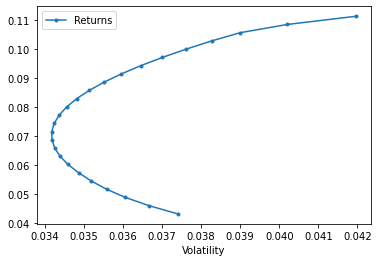

In [11]:
x = ['Fin', 'Games', 'Telcm', 'Rtail']
plot_ef(25, er[x], cov.loc[x,x])